# Image segmentation

In dit voorbeeld zullen we gebruik maken van de Oxford Pets Dataset. Het model zal leren om objecten (bijv. huisdieren) van de achtergrond te onderscheiden.
We gebruiken hiervoor de U-Net architectuur, een populair model voor afbeeldingssegmentatie. 
Er zijn verscheidene manieren om deze dataset te gebruiken maar in de code hieronder gebruiken we [deze dataset](https://www.kaggle.com/datasets/devdgohil/the-oxfordiiit-pet-dataset)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from tqdm import tqdm
import kagglehub
import tarfile

# Controleren of GPU beschikbaar is
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Dataset gedownload naar: /root/.cache/kagglehub/datasets/devdgohil/the-oxfordiiit-pet-dataset/versions/2


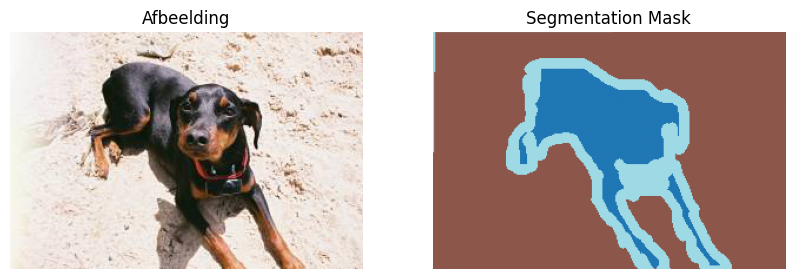

In [3]:
path = kagglehub.dataset_download("devdgohil/the-oxfordiiit-pet-dataset")
print("Dataset gedownload naar:", path)

# In deze dataset zijn de mappen meestal: images/ en annotations/
images_dir = os.path.join(path, "images/images")
masks_dir = os.path.join(path, "annotations/annotations", "trimaps")

# Kies een willekeurige afbeelding
filename = os.listdir(images_dir)[0]  # eerste bestand
image_path = os.path.join(images_dir, filename)

# Het corresponderende mask heeft dezelfde naam maar extensie .png
mask_name = os.path.splitext(filename)[0] + ".png"
mask_path = os.path.join(masks_dir, mask_name)

# Laad image en mask
image = Image.open(image_path).convert("RGB")
mask = Image.open(mask_path)

# Zet het mask om naar numpy array
mask_array = np.array(mask)

# Plot image en mask
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(image)
axes[0].set_title("Afbeelding")
axes[0].axis("off")

axes[1].imshow(mask_array, cmap="tab20")
axes[1].set_title("Segmentation Mask")
axes[1].axis("off")

plt.show()

## Dataset inladen

Maak nu een Dataset aan die
* Alle jpg-bestanden zoekt in de images folder (zie hierboven) (let op dat je de .mat bestanden negeert)
* Ze allemaal resized naar 572x572 pixels (standaard resolutie van UNet)
* Ze omzet naar een tensor
* Lees voor elke filenaam de behorende segmentation mask in (zie ook hierboven (trimaps). Dit is de output. Let op dat je het mask ook Resized en omzet naar een Tensor.
* Pas het segmentation mask aan. Het originele mask heeft drie waarden (1,2,3). We willen 1 omzetten naar 0 en 2/3 omzetten naar 1. Op deze manier kunnen we gebruik maken van binaire classificatie. Tip: de where functie in pytorch

In [4]:
transform = transforms.Compose([
    transforms.Resize((572, 572)),
    transforms.ToTensor()
])

class OxfordPetsDataset(data.Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, output_size=388):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.output_size = output_size

        self.images_files = [f for f in os.listdir(self.images_dir) if f.endswith('.jpg')]
        self.masks_files = [f for f in os.listdir(self.masks_dir) if f.endswith('.png') and not f.startswith(".")]

    def __len__(self):
        return len(self.images_files)

    def __getitem__(self, idx):
        # inlezen
        img_path = os.path.join(self.images_dir, self.images_files[idx])
        image = Image.open(img_path).convert('RGB')
        # preprocessen
        if self.transform:
            image = self.transform(image)

        # inlezen
        mask_path = os.path.join(self.masks_dir, self.masks_files[idx])
        mask = Image.open(mask_path)
        mask = transforms.PILToTensor()(mask)
        mask = transforms.Resize((self.output_size, self.output_size))(mask)

        # mask bevat 3 klassen (1,2,3) -> wij willen (0 en 1)
        mask = mask.squeeze(0)
        mask = torch.where(mask >= 2.0, torch.ones_like(mask, dtype=torch.float), torch.zeros_like(mask, dtype=torch.float))

        return image, mask        

train_dataset = OxfordPetsDataset(images_dir, masks_dir, transform)
train_loader = data.DataLoader(train_dataset, batch_size=2, shuffle=True)

for images, masks in train_loader:
    print(images.shape)
    print(masks.shape)
    print(masks.max())
    print(masks.min())
    break

torch.Size([2, 3, 572, 572])
torch.Size([2, 388, 388])
tensor(1.)
tensor(0.)


## Samenstellen van het U-net model

Nu bouwen we het UNet op. Dit model heeft een U vormige structuur waarbij eerst de resolutie afneemt en daarna terug opgebouwd wordt tot de originele resolutie.
Een visuele weergave van dit netwerk is 

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20220614121231/Group14.jpg">

Hiervoor worden de volgende stappen gebruikt:

* Een **eerste convolutionele block** om van 3 kanalen (rgb) naar 64 (aantal outputkernels) te gaan. Deze block doet de volgende stappen:
  * Een convolutionele laag met 64 kernels van 3x3 zonder padding
  * Een convolutionele laag met 64 kernels van 3x3 zonder padding
* Een maxpooling layer om de resolutie te halveren
* Een **tweede convolutionele block** met 128 outputkernels
* Een maxpooling layer om de resolutie te halveren
* Een **derde convolutionele block** met 256 outputkernels
* Een maxpooling layer om de resolutie te halveren
* Een **vierde  convolutionele block** met 512 outputkernels
* Een maxpooling layer om de resolutie te halveren
* Een bottleneck block dat gelijk is aan **convolutionele block** met 512 outputkernels
* Daarna volgt een eerste **decoding block**. Deze block doet de volgende stappen:
  * Upsample de output van de **bottleneck** (nn.functional.interpolate) om de resolutie te verdubbelen.
  * Resize de output van de **vierde convolutionele block** wordt geresized naar de afmetingen na upsampling.
  * De output van deze twee stappen wordt geconcateneerd en vormt de input van de volgende stappen (in totaal 512 + 512 = 1024 kanalen)
  * Een convolutionele laag met aantal outputkernels 512, kernel_size 3x3 en geen padding
  * Een convolutionele laag met aantal outputkernels 256 
* Een **tweede decoding block** die de output van de vorige decoding block combineert met de **derde convolutionele block**. Het aantal outputkernels in deze block is respectievelijk 256 en 128.
* Een **derde decoding block** die de output van de vorige decoding block combineert met de **tweede convolutionele block**. Het aantal outputkernels in deze block is respectievelijk 198 en 64.
* Een **vierde decoding block** die de output van de vorige decoding block combineert met de **eerste convolutionele block**. Het aantal outputkernels in deze block is respectievelijk 64 en 64.
* Een laatste convolutionele laag met kernel_size 1 en geen padding om naar het gewenste aantal outputklassen te gaan (met binaire classificatie kan dit 1 zijn)

Bouw dit model in de code-cell hieronder met behulp van de nn.Module klasse in pytorch. Doe dit stap per stap en print elke keer de outputshape uit van het resultaat. Dit kan je helpen om de nodige lagen op de juiste manier aan elkaar te koppelen

In [5]:
class UNet(nn.Module):

    def __init__(self):
        super(UNet, self).__init__()

        # maak de lagen
        self.enc_block1 = self.conv_block(3, [64, 64])
        self.enc_block2 = self.conv_block(64, [128, 128 ])
        self.enc_block3 = self.conv_block(128, [256, 256])
        self.enc_block4 = self.conv_block(256, [512, 512])

        self.bottleneck = self.conv_block(512, [1024, 512])
        
        self.dec_block4 = self.conv_block(1024, [512, 256])
        self.dec_block3 = self.conv_block(512, [256, 128])
        self.dec_block2 = self.conv_block(256, [128, 64])
        self.dec_block1 = self.conv_block(128, [64, 64])

        self.final_conv = nn.Conv2d(64, 1, kernel_size=1, stride=1, padding=0)
        # het aantal kernels in deze laatste laag bepaalt het aantal klassen
        # hier binary cross entropy dus 2 klassen maar 1 kernel volstaat

        self.maxpool = nn.MaxPool2d(2)

    def forward(self, x):
        # de forward pass
       # print(x.shape)
       # print(self.enc_block1)
        enc_block1 = self.enc_block1(x)
        
       # print(enc_block1.shape)
        enc_block2 = self.enc_block2(self.maxpool(enc_block1))
        enc_block3 = self.enc_block3(self.maxpool(enc_block2))
        enc_block4 = self.enc_block4(self.maxpool(enc_block3))

        bottleneck = self.bottleneck(self.maxpool(enc_block4))

        # upsample (grijs + groen uit de slides)
        bottleneck = self.upsample_and_concat(bottleneck, enc_block4)
        output = self.dec_block4(bottleneck)

        # upsample 
        output = self.upsample_and_concat(output, enc_block3)
        output = self.dec_block3(output)

        # upsample
        output = self.upsample_and_concat(output, enc_block2)
        output = self.dec_block2(output)

        # upsample
        output = self.upsample_and_concat(output, enc_block1)
        output = self.dec_block1(output)

        return self.final_conv(output)

    def upsample_and_concat(self, x1, x2):
        # de groene pijl (x1) -> upsampling met factor 2, omgekeerde van maxpool
        x1_new = nn.functional.interpolate(x1, scale_factor=2, mode='bilinear')

        # de grijze pijl (resizen naar dimensies van x1new (na upsampling)
        x2_new = transforms.functional.resize(x2, x1_new.shape[2])

        # aan elkaar plakken
        return torch.cat([x1_new, x2_new], dim=1)

    def conv_block(self, in_channels, out_channels_list):
        layers = []
        for out_channels in out_channels_list:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=0))
            layers.append(nn.ReLU())
            in_channels=out_channels
        # geen maxpool omdat deze functie ook gebruikt gaat worden in de rechterkant van het UNET

        return nn.Sequential(*layers) # maak een sequentieel model van deze blok

model = UNet()

Stuur nu 1 batch door het netwerk om te controleren of alle lagen correct uitgevoerd worden en er geen errors zijn

In [6]:
for images, masks in train_loader:
    print(images.shape, masks.shape)
    outputs = model(images)
    print(outputs.shape)
    break

torch.Size([2, 3, 572, 572]) torch.Size([2, 388, 388])
torch.Size([2, 1, 388, 388])


## Training loop

In [7]:
model_path = "model_segmentation.pth"

# Move model to device
model = model.to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

if os.path.exists(model_path):
    print("Loading model from disk...")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  # set to eval mode since we won’t retrain
else:
    print("No saved model found, training...")
    num_epochs = 2
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        for idx, (images, masks) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device)

            model.zero_grad(set_to_none=True)
            outputs = model(images)
            loss = criterion(outputs, masks.unsqueeze(1))
            loss.backward()
            optimizer.step()

            if idx % 100 == 0:
                print(f"Busy with batch {idx}/{len(train_loader)}")

            running_loss += loss.item()

        print(f"Epoch {epoch}: running loss is {running_loss / len(train_loader)}")

    # Save model after training
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

Loading model from disk...


## Evaluatie

tensor([0., 1.], device='cuda:0')


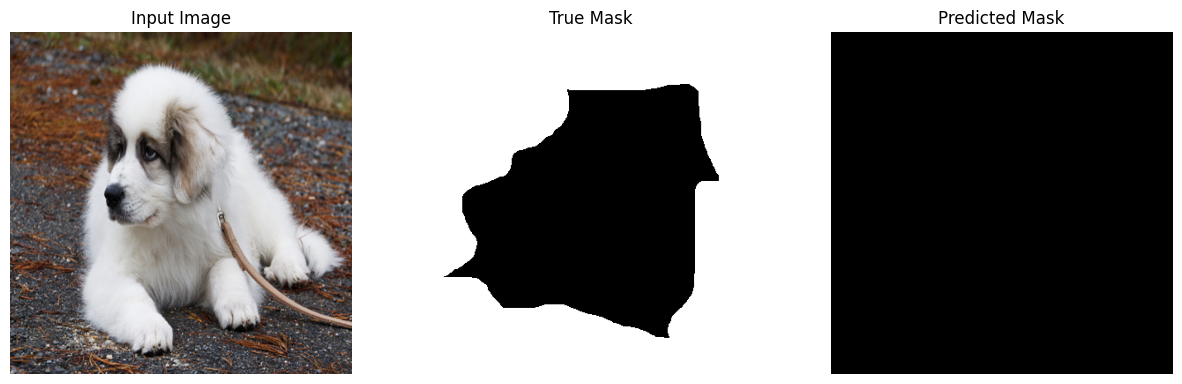

In [8]:
# Evalueren en Visualiseren
model.eval()

def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].cpu().numpy().squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

# Testen op enkele voorbeelden
with torch.no_grad():
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        predictions = model(images)
        print(masks[0].unique())
        predictions = (predictions > 0.5).float()  # Thresholding
        display([images[0].permute(1, 2, 0), masks[0], predictions[0]])
        break

# Kleiner model om te testen

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_dataset = OxfordPetsDataset(images_dir, masks_dir, transform, output_size=128)
train_loader = data.DataLoader(train_dataset, batch_size=2, shuffle=True)

for images, masks in train_loader:
    print(images.shape)
    print(masks.shape)
    print(masks.max())
    print(masks.min())
    break

encoder = nn.Sequential(
    nn.Conv2d(3, 16, stride=1, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 32, stride=1, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, stride=1, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 128, stride=1, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2)
)

decoder = nn.Sequential(
    nn.ConvTranspose2d(128, 64, stride=1, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Upsample(scale_factor=2),
    nn.ConvTranspose2d(64, 32, stride=1, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Upsample(scale_factor=2),
    nn.ConvTranspose2d(32, 16, stride=1, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Upsample(scale_factor=2),
    nn.ConvTranspose2d(16, 1, stride=1, kernel_size=3, padding=1),
    nn.Upsample(scale_factor=2),
    nn.Sigmoid() # dit kan veranderen afhankelijk van de gewenste loss-functie
    # ook bij beelden wordt sigmoid gebruikts
)

small_model = nn.Sequential(encoder, decoder)

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs=2
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for idx, (images, masks) in enumerate(train_loader):
        #optimizer.zero_grad()
        small_model.zero_grad(set_to_none=True)
        outputs = small_model(images)
        loss = criterion(outputs, masks.unsqueeze(1))
        loss.backward()
        optimizer.step()

        if idx%10==0:
            print(f"Busy with batch {idx}/{len(train_loader)}")

        running_loss += loss.item()
        
    print(f"Epoch {epoch}: running loss is {running_loss / len(train_loader)}")

In [ ]:
model.eval()

def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].cpu().numpy().squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

# Testen op enkele voorbeelden
with torch.no_grad():
    for images, masks in train_loader:
        predictions = small_model(images)
        print(masks[0].unique())
        predictions = (predictions > 0.5).float()*255  # Thresholding
        display([images[0].permute(1, 2, 0), masks[0], predictions[0]])
        break